In [1]:
import numpy as np
import pandas as pd
import re

In [2]:
path = "data/safe_returns.csv"
df = pd.read_csv(path)


df.set_index("date", inplace=True)
print(df.head())


              0    A   AA  AAL  AAP  AAPL  AAS  ABBV  ABC  ABMD  ...  XOM  \
date                                                             ...        
2001-01-02  0.0  0.0  0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0  ...  0.0   
2001-01-03  0.0  0.0  0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0  ...  0.0   
2001-01-04  0.0  0.0  0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0  ...  0.0   
2001-01-05  0.0  0.0  0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0  ...  0.0   
2001-01-08  0.0  0.0  0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0  ...  0.0   

            XRAY  XYL  YUM  ZBH  ZBRA  ZION  ZMH  ZMX  ZTS  
date                                                        
2001-01-02   0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  
2001-01-03   0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  
2001-01-04   0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  
2001-01-05   0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  
2001-01-08   0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  

[5 rows x 667 columns]


### PCA factors regression

Here, we use the fact that via PCA decomposition, we have

R = PSQ
P is N*K matrix. Assuming we "learn" this,
we could input the new Q each day: K\*1 (the factors that day). Then we make a prediction on N\*1 market return


In [3]:
ratio = 0.8
train_size = int(len(df) * ratio)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

train_data.head()

,0,A,AA,AAL,AAP,AAPL,AAS,ABBV,ABC,ABMD,...,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZMH,ZMX,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2001-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
from sklearn.decomposition import PCA

K = 5  # Number of principal components/factors, you can set this as needed

# Perform PCA decomposition on the training data
pca = PCA(n_components=K)
P = pca.fit(train_data.values)      # Shape: (N, K), N = number of timestamps/rows in train_data, but you want N = number of assets
print((P.components_.shape))


(5, 667)


In [6]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from tqdm import tqdm

returns = df
window = 252
n_factors = 5
ridge_alpha = 1e-2
pca_refit_freq = 30  # Refit PCA every 30 days

dates = returns.index
N = returns.shape[1]
T = len(returns)
preds = np.full_like(returns.values, np.nan)

betas = np.zeros((T-window-1, N, n_factors))
alphas = np.zeros((T-window-1, N))

# Precompute a regularization matrix for efficiency
ridge_eye = ridge_alpha * np.eye(n_factors+1)

# Cache for PCA model and factors
pca = None
F_win = None
last_pca_fit = -pca_refit_freq  # Force initial fit

for t in tqdm(range(window, T-1), desc="Rolling PCA+Ridge", miniters=200):
    # 1️⃣ Refit PCA every 30 days
    if t - last_pca_fit >= pca_refit_freq:
        X_win = returns.values[t-window:t, :]
        pca = PCA(n_components=n_factors)
        F_win = pca.fit_transform(X_win)  # (window, K)
        last_pca_fit = t
    else:
        # Transform only the new data point using existing PCA
        X_new = returns.values[t-1:t, :]  # (1, N)
        F_new = pca.transform(X_new)  # (1, K)
        # Append to factor history and remove oldest
        F_win = np.vstack([F_win[1:], F_new])  # Keep window size constant
    
    F_t = F_win[-1]  # (K,)

    # 2️⃣ Ridge regression via vectorized closed-form
    # We'll fit over the last 100 days, but adapt window if not enough data
    hist_len = min(100, F_win.shape[0])
    F_hist = F_win[-hist_len:]             # (M, K)
    R_hist = returns.values[t-hist_len+1:t+1, :]  # (M, N); next-day aligned

    # Prepare design with intercept
    X = np.hstack([np.ones((hist_len,1), dtype=float), F_hist])   # (M, K+1)
    # Precompute cross-products
    XtX = X.T @ X + ridge_eye
    XtY = X.T @ R_hist   # (K+1, N)
    coef = np.linalg.solve(XtX, XtY)  # (K+1, N)
    alpha_t = coef[0]
    beta_t = coef[1:].T  # (N, K)

    # 3️⃣ Prediction
    preds[t+1, :] = alpha_t + beta_t @ F_t

    betas[t-window, :, :] = beta_t
    alphas[t-window, :] = alpha_t

pred_df = pd.DataFrame(preds, index=returns.index, columns=returns.columns)


Rolling PCA+Ridge: 100%|██████████| 5784/5784 [05:13<00:00, 18.44it/s]


In [8]:
pred_df.tail()

,0,A,AA,AAL,AAP,AAPL,AAS,ABBV,ABC,ABMD,...,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZMH,ZMX,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2024-12-24,0.0,-0.450377,0.0,-0.118797,0.097352,0.071705,0.0,-0.332395,0.0,0.0,...,0.010645,0.087477,-0.223997,-0.230189,-0.374878,0.019927,-0.019796,0.0,0.0,-0.722160
2024-12-26,0.0,-0.073855,0.0,0.177995,0.062781,0.070498,0.0,-0.166755,0.0,0.0,...,-0.039941,0.192745,0.057162,-0.069718,-0.015009,0.028743,0.107738,0.0,0.0,-0.158449
2024-12-27,0.0,-0.130362,0.0,0.137319,0.277152,0.104498,0.0,-0.326579,0.0,0.0,...,0.003015,-0.006017,0.070297,0.089728,-0.142298,0.199619,0.228747,0.0,0.0,-0.283933
2024-12-30,0.0,-0.131194,0.0,0.090868,0.008011,0.002185,0.0,-0.107454,0.0,0.0,...,-0.095507,0.105201,-0.113904,-0.078164,-0.077392,-0.042023,-0.090113,0.0,0.0,-0.224198
2024-12-31,0.0,0.067025,0.0,0.244673,-0.063918,-0.054084,0.0,-0.149473,0.0,0.0,...,-0.127147,0.378250,-0.100376,-0.239416,-0.062676,-0.036893,-0.067851,0.0,0.0,-0.080672


In [9]:
returns.tail()

,0,A,AA,AAL,AAP,AAPL,AAS,ABBV,ABC,ABMD,...,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZMH,ZMX,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2024-12-24,0.0,0.787997,0.0,-0.061959,-0.090592,0.868619,0.0,0.477185,0.0,0.0,...,0.214074,0.058545,0.509732,0.944217,0.327543,0.751280,0.280626,0.0,0.0,0.391530
2024-12-26,0.0,-0.053279,0.0,-0.270378,0.272936,0.082890,0.0,-0.143724,0.0,0.0,...,0.247529,0.445075,0.316539,0.805733,-0.039613,0.139924,0.118968,0.0,0.0,0.556624
2024-12-27,0.0,-0.060750,0.0,-0.279625,-0.236594,-1.442696,0.0,-0.240536,0.0,0.0,...,0.186199,-0.194953,-0.391443,-0.537785,-0.281029,-1.398803,-0.553506,0.0,0.0,-0.224617
2024-12-30,0.0,-0.457002,0.0,0.230762,1.341936,-1.411944,0.0,-0.400597,0.0,0.0,...,-0.399970,-0.288957,-0.572058,-1.282608,-1.033839,-0.977896,-0.345347,0.0,0.0,-0.859287
2024-12-31,0.0,0.035232,0.0,-0.615509,0.737179,-0.811794,0.0,0.449554,0.0,0.0,...,1.796679,0.536707,-0.000941,0.528452,0.143120,0.353365,-0.135238,0.0,0.0,0.492135


### neural network

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

# Assume `returns` is a (T, N) pandas DataFrame, indexed by date
X_all = torch.tensor(returns.shift(1).iloc[1:].values, dtype=torch.float32)  # r_t
y_all = torch.tensor(returns.iloc[1:].values, dtype=torch.float32)           # r_{t+1}
T, N = X_all.shape

# --------------- Train/Test Split (preserve order) ---------------
split_idx = int(T * 0.8)
X_train, X_test = X_all[:split_idx], X_all[split_idx:]
y_train, y_test = y_all[:split_idx], y_all[split_idx:]

# --------------- Normalize using training set only ---------------
# mean = X_train.mean(0, keepdim=True)
# std = X_train.std(0, keepdim=True) + 1e-6
# X_train = (X_train - mean) / std
# y_train = (y_train - mean) / std
# X_test = (X_test - mean) / std
# y_test = (y_test - mean) / std

# --------------- Neural Network Definition ---------------
class ReturnPredictor(nn.Module):
    def __init__(self, N, hidden_dim=256, depth=3, dropout=0.1):
        super().__init__()
        layers = []
        in_dim = N
        for _ in range(depth):
            layers += [
                nn.Linear(in_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.BatchNorm1d(hidden_dim)
            ]
            in_dim = hidden_dim
        layers.append(nn.Linear(in_dim, N))  # output dimension N
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

model = ReturnPredictor(N, hidden_dim=3, depth=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# --------------- Training Loop ---------------
n_epochs = 200
batch_size = 32
T_train = len(X_train)

for epoch in range(n_epochs):
    total_loss = 0
    for i in range(0, T_train, batch_size):
        Xb = X_train[i:i+batch_size]
        yb = y_train[i:i+batch_size]
        optimizer.zero_grad()
        y_pred = model(Xb)
        loss = criterion(y_pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(Xb)
    if (epoch+1) % 10 == 0:
        avg_loss = total_loss / T_train
        print(f"Epoch {epoch+1:03d} | Train Loss {avg_loss:.6f}")

# --------------- Evaluation ---------------
with torch.no_grad():
    y_pred_train = model(X_train)
    y_pred_test = model(X_test)

def r2_score(y_true, y_pred):
    ss_res = ((y_true - y_pred)**2).sum().item()
    ss_tot = ((y_true)**2).sum().item()
    return 1 - ss_res / ss_tot

r2_train = r2_score(y_train, y_pred_train)
r2_test  = r2_score(y_test,  y_pred_test)

print(f"\nTrain R² = {r2_train:.4f}")
print(f" Test R² = {r2_test:.4f}")

# --------------- Convert predictions back to DataFrame ---------------
# y_hat_test = (y_pred_test * std + mean).numpy()
# pred_df = pd.DataFrame(
#     y_hat_test,
#     index=returns.index[1:][split_idx:],
#     columns=returns.columns
# )



Epoch 010 | Train Loss 0.733892
Epoch 020 | Train Loss 0.722844
Epoch 030 | Train Loss 0.702107
Epoch 040 | Train Loss 0.691390
Epoch 050 | Train Loss 0.689487
Epoch 060 | Train Loss 0.681953
Epoch 070 | Train Loss 0.678110
Epoch 080 | Train Loss 0.678420
Epoch 090 | Train Loss 0.675786
Epoch 100 | Train Loss 0.676974
Epoch 110 | Train Loss 0.674795
Epoch 120 | Train Loss 0.678983
Epoch 130 | Train Loss 0.674972
Epoch 140 | Train Loss 0.675018
Epoch 150 | Train Loss 0.673015
Epoch 160 | Train Loss 0.673455
Epoch 170 | Train Loss 0.670750
Epoch 180 | Train Loss 0.669292
Epoch 190 | Train Loss 0.668959
Epoch 200 | Train Loss 0.668307

Train R² = 0.0686
 Test R² = -0.0838


In [57]:
returns.to_csv("returns.csv")

### evaluation

In [10]:
import numpy as np
import pandas as pd

# Align the two DataFrames just in case
pred_df, ret_df = pred_df.align(returns, join='inner', axis=0)

# Flatten NaNs (drop dates without predictions)
mask = ~np.isnan(pred_df.values) & ~np.isnan(ret_df.values)
y_true = ret_df.values[mask]
y_pred = pred_df.values[mask]

# ---------- 1. Overall R^2 ----------
ss_res = np.sum((y_true - y_pred) ** 2)
ss_tot = np.sum((y_true) ** 2)
r2_overall = 1 - ss_res / ss_tot
print(f"Overall R^2: {r2_overall:.6f}")

# ---------- 2. Per-stock R^2 ----------
# compute column-wise R^2 for each stock
r2_per_stock = 1 - ((ret_df - pred_df)**2).sum() / ((ret_df)**2).sum()
r2_per_stock = r2_per_stock.to_frame("R2")
print(r2_per_stock.sort_values("R2", ascending=True).head())


Overall R^2: -0.065444
            R2
MSS  -0.110266
FOH  -0.103300
META -0.096467
MLSS -0.090229
LNX  -0.089734


In [11]:
((ret_df - pred_df)**2).sum()

0          0.000000
A       6273.806660
AA      3934.365050
AAL     2877.932837
AAP     6089.119690
           ...     
ZBRA    6063.255911
ZION    6288.276649
ZMH     3535.109750
ZMX      387.363523
ZTS     3182.188698
Length: 667, dtype: float64

In [12]:
(ret_df**2).sum()

0          0.000000
A       5984.833696
AA      3932.067268
AAL     2779.573813
AAP     5727.204047
           ...     
ZBRA    5890.561001
ZION    6067.438461
ZMH     3384.236083
ZMX      551.341570
ZTS     2967.911166
Length: 667, dtype: float64

In [13]:
((ret_df - pred_df)**2).sum() / ((ret_df)**2).sum()

0            NaN
A       1.048284
AA      1.000584
AAL     1.035386
AAP     1.063192
          ...   
ZBRA    1.029317
ZION    1.036397
ZMH     1.044581
ZMX     0.702584
ZTS     1.072198
Length: 667, dtype: float64

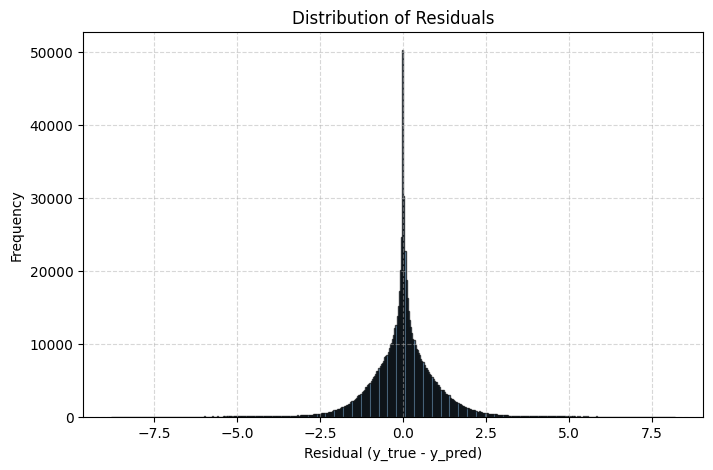

In [22]:
import matplotlib.pyplot as plt

# Compute residuals
residuals = y_true - y_pred

plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=500, alpha=0.7, color='steelblue', edgecolor='black')
plt.title("Distribution of Residuals")
plt.xlabel("Residual (y_true - y_pred)")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
